In [28]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

# sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# keras 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

#print('Notebook run using keras:', keras.__version__)

In [29]:
# UDFs ----

def scrape_frames(video_name, dest_path, n_images, skip_seconds):
    # function for scraping frames from videos
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    # function for moving random files from one directory to another (used for creating train and test set)
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    # function for previewing a random image from a given directory
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
def img_to_1d_greyscale(img_path, size):
    # function for loading, resizing and converting an image into greyscale
    # used for logistic regression
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

def show_image(image):
    # function for viewing an image
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    # function for transforming images into a format supported by CNN
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)
    

### Previewing images

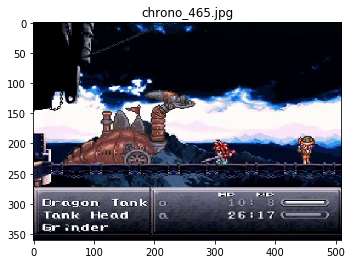

Dimensions: (510, 360) Total pixels: 183600


In [30]:
preview_random_image('training_set/chrono/')

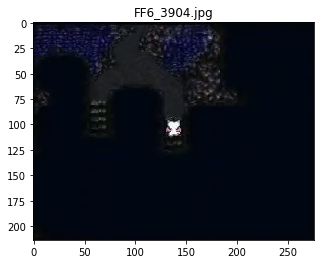

Dimensions: (276, 214) Total pixels: 59064


In [31]:
preview_random_image('training_set/FF6/')

In [32]:
#training and test sets
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (100, 100),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 3 classes.
Found 2000 images belonging to 2 classes.


In [33]:
# inspecting class labels for future reference 
labels_index = { 1 : "chrono", 0 : "FF6"}
training_set.class_indices

{'FF6': 0, 'chrono': 1, 'ipynb_checkpoints': 2}

### Initialising CNN

In [ ]:
# Initialising 
cnn_classifier = Sequential()

# 1st conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (100, 100, 3), activation = 'relu'))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 3nd conv. layer
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
cnn_classifier.add(Flatten())

# Full connection
cnn_classifier.add(Dense(units = 64, activation = 'relu'))
cnn_classifier.add(Dropout(0.2)) # quite aggresive dropout, maybe reduce
cnn_classifier.add(Dense(units = 1, activation = 'sigmoid'))

cnn_classifier.summary()

In [ ]:
# Compiling the CNN
cnn_classifier.compile(optimizer = 'adam', # 'adam'/rmsprop'
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

### Fitting the model

In [ ]:
cnn_classifier.fit_generator(training_set,
                             steps_per_epoch = 2000,
                             epochs = 1,
                             validation_data = test_set,
                             validation_steps = 2000)

In [ ]:
# saving model and weights 
cnn_classifier.save_weights('chrono_vs_FF6_model.h5')
cnn_classifier.save('chrono_vs_FF6_model.h5')

In [34]:
# load the model 

cnn_classifier = keras.models.load_model('chrono_vs_FF6_model.h5')

### Evaluating the results

In [35]:
#preparing data for predictions

size = (100, 100)
X_eval = list()
y_eval = list()

# chrono part
files = os.listdir('test_set/chrono')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/chrono/' + files[i + 1], size))
    y_eval.append(1)

# FF6 part
files = os.listdir('test_set/FF6')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/FF6/' + files[i + 1], size))
    y_eval.append(0)

# stacking the arrays   
X_eval = np.vstack(X_eval)
    

In [36]:
cnn_pred = cnn_classifier.predict_classes(X_eval, batch_size = 32)

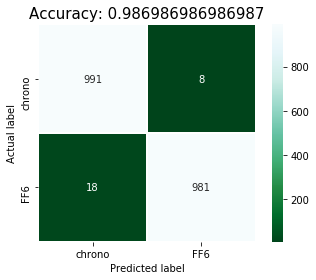

In [37]:
pretty_cm(cnn_pred, y_eval, ['chrono','FF6'])

### Explaining the results with LIME

In [38]:
correctly_classified_indices, misclassified_indices = evaluation_indices(cnn_pred, y_eval)

#### correctly classified images

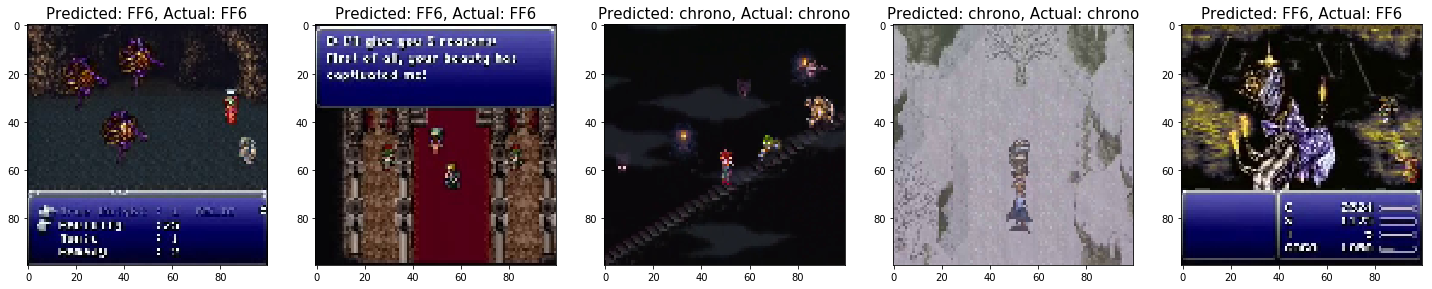

In [39]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

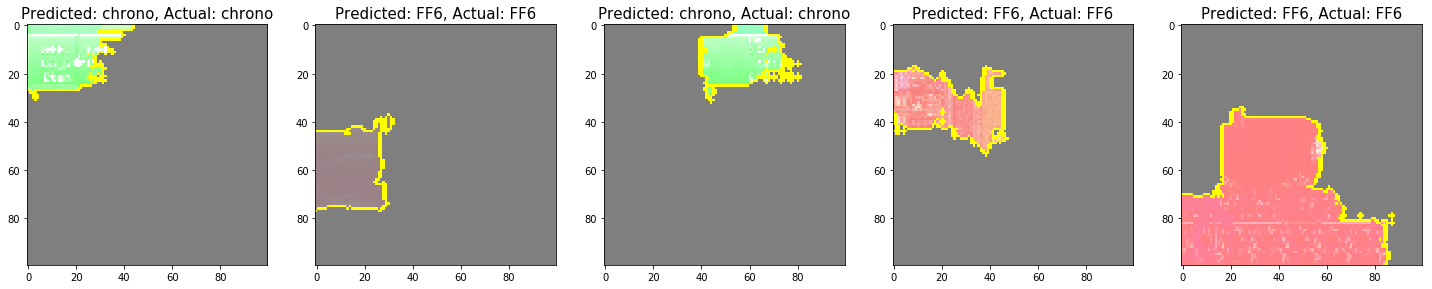

In [46]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[good_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=1, hide_rest=True)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)


#### misclassified images

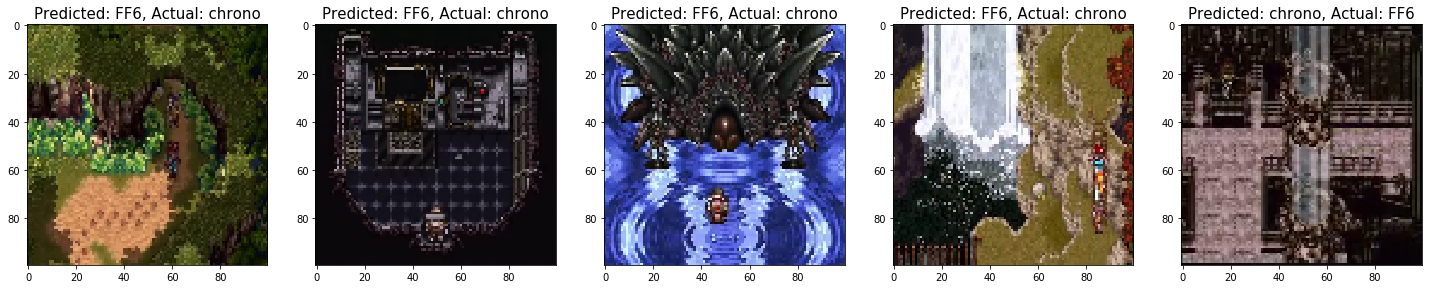

In [41]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[bad_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)

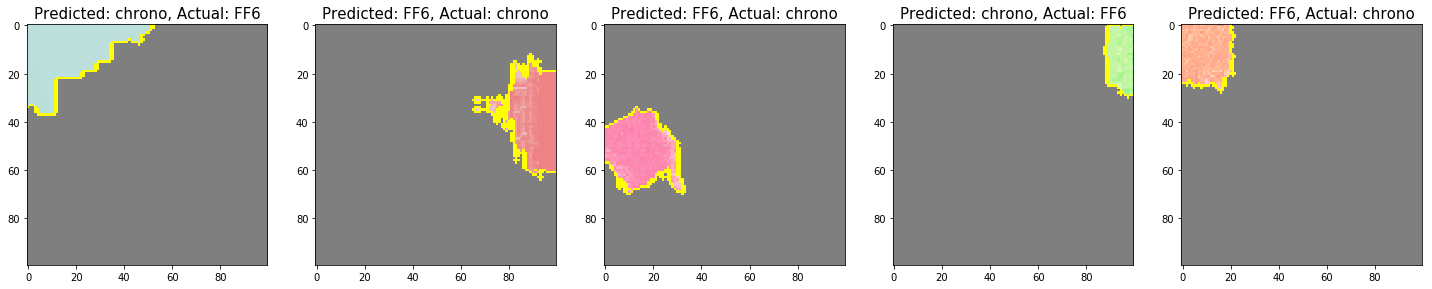

In [44]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[bad_index], cnn_classifier.predict_classes, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=1, hide_rest=True)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)
